In [32]:
from icecube import dataio,dataclasses
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new/")

from lib.geo import get_xyz_from_zenith_azimuth
from lib.geo import __theta_cherenkov
__theta_cherenkov_deg = np.rad2deg(__theta_cherenkov)
print(__theta_cherenkov_deg)

40.134791222536876


In [33]:
f = dataio.I3File('/home/storage/hans/jax_reco_new/extract_data_from_i3files/test.i3.zst')
g = dataio.I3File('/home/storage2/hans/i3files/GeoCalibDetectorStatus_2020.Run134142.Pass2_V0.i3.gz')
g_frame = g.pop_frame()
geo = g_frame['I3Geometry'].omgeo

(0.001, 1000)

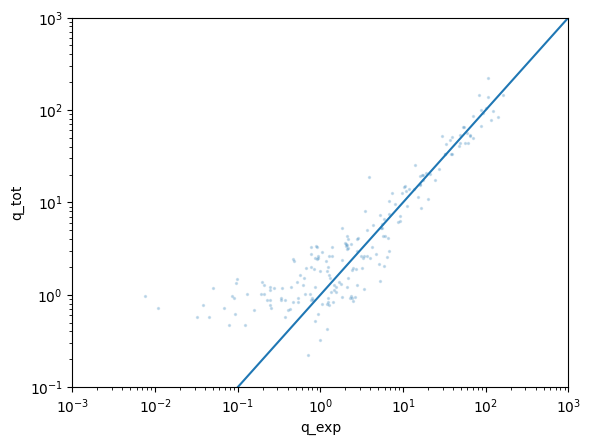

In [34]:
frame = f.pop_physics()
expq_dict = frame['MCMostEnergeticTrack_I3MCTree_ExQ']
obsq_dict = dict()

pmap = dataclasses.I3RecoPulseSeriesMap.from_frame(frame, "TWSRTHVInIcePulsesIC")
for om, pulses in pmap.items():
    obsq_dict[om] = np.sum([p.charge for p in pulses])


qexp_list = []
qtot_list = []
#for key in pmap.keys():
    #qtot = sum([p.charge for p in pulses[key]])

for key, qtot in obsq_dict.items():
    qexp = sum(expq_dict[key])
    qexp_list.append(qexp)
    qtot_list.append(qtot)


fig, ax = plt.subplots()
plt.scatter(qexp_list, qtot_list, s=2, alpha=0.2)
plt.plot([0.001, 1000], [0.001, 1000])
plt.xlabel('q_exp')
plt.ylabel('q_tot')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 10**3])
plt.xlim([0.001, 10**3])

In [35]:
import numpy as np

In [36]:
xd = np.array([0., 1.])
x0 = np.array([0., 1.])
x1 = np.array([1., -1.])

x2 = x1-x0
x2 = x2 / np.linalg.norm(x2)
print(x2)

[ 0.4472136  -0.89442719]


In [37]:
np.dot(x2, xd)

-0.8944271909999159

In [38]:
np.rad2deg(np.arccos(np.dot(x2, xd)))

153.434948822922

In [39]:
I3MCTree = frame['I3MCTree']

loss_pos = []
for p in I3MCTree.get_daughters(I3MCTree[0]):
     for loss in I3MCTree.get_daughters(p):
           if not 'Mu' in str(loss.type):
                pos = loss.pos
                loss_pos.append([pos.x, pos.y, pos.z])

loss_pos = jnp.array(loss_pos)
print(loss_pos.shape)

dom_pos = []
q_exp = []
q_tot = []
for key in obsq_dict.keys():
    pos = geo[key].position
    dom_pos.append([pos.x, pos.y, pos.z])
    q_exp.append(expq_dict[key])
    q_tot.append(obsq_dict[key])

q_exp = jnp.array(q_exp)
dom_pos = jnp.array(dom_pos)
q_tot = jnp.array(q_tot)
print(dom_pos.shape)
print(q_exp.shape)
print(q_tot.shape)

mctruth = frame['MCMostEnergeticTrack']
track_dir_xyz = get_xyz_from_zenith_azimuth([mctruth.dir.zenith, mctruth.dir.azimuth])
track_pos = jnp.array([mctruth.pos.x, mctruth.pos.y, mctruth.pos.z])

(345, 3)
(201, 3)
(201, 345)
(201,)


In [51]:
def closest_distance_dom_track(dom_pos, track_pos, track_dir):
    """
    dom_pos: 1D jax array with 3 components [x, y, z]
    track_pos: 1D jax array with 3 components [x, y, z]
    track_dir: 1D jax array with 3 components [dir_x, dir_y, dir_z]
    """

    # vector track vertex -> dom
    v_a = dom_pos - track_pos
    # vector: closest point on track -> dom
    v_d = v_a - jnp.dot(v_a, track_dir) * track_dir
    dist = jnp.linalg.norm(v_d)
    return dist


def asym_gaussian(diff, sigma, r):
    t1 = jnp.exp(-0.5 * (diff / sigma)**2)
    t2 = jnp.exp(-0.5 * (diff / (r * sigma))**2)
    return jnp.where(diff > 0, t1, t2)

def get_corrected_charge(dom_pos, q_exp, loss_pos, track_pos, track_dir):
    # dom_pos: location of single dom. shape = (3,)
    # loss_pos: location of all losses. shape = (N_losses, 3)
    # track_dir: direction of track in cartesian coords. shape = (3,)
    # q_exp: vector of expected charge from each loss for this dom. shape = (N_losses,)
    # returns correction factor for qtot for this dom

    # compute vectors between dom and losses
    # shape: N_loss, 3    
    dx = dom_pos - loss_pos
    dx_normed = dx / jnp.expand_dims(jnp.linalg.norm(dx, axis=1), axis=1)

    # angle between line from loss to dom and track direction
    delta = jnp.arccos(jnp.clip(jnp.dot(dx_normed, track_dir), min=-1.0, max=1.0))
    
    delta_ = jnp.where(delta < jnp.pi/2.0, delta, jnp.pi-delta)
    delta_ = jnp.where(delta == jnp.pi/2.0, delta_-0.001, delta_)

    dist = closest_distance_dom_track(dom_pos, track_pos, track_dir)
    yc = dist / jnp.tan(__theta_cherenkov)
    yl = dist / jnp.tan(delta_)

    dy = jnp.where(delta < __theta_cherenkov, yl - yc, -(yc - yl))
    dy = jnp.where(delta < jnp.pi/2, dy, -(yl + yc))
    dy = jnp.where(delta != jnp.pi/2, dy, -yc)

    dx = dy / dist
    
    
    sigma = 0.8
    r = 1.0
    weights = asym_gaussian(dx, sigma, r)
    return jnp.sum(weights * q_exp) / jnp.sum(q_exp)

get_corrected_charge_v = jax.vmap(get_corrected_charge, (0, 0, None, None, None), 0)

In [52]:
for i in range(len(q_tot)):
    da = get_corrected_charge(dom_pos[i], q_exp[i], loss_pos, track_pos, track_dir_xyz)
    print(da, q_tot[i], da * q_tot[i])

0.8334702932518977 1.125 0.9376540799083849
0.3811723340213117 1.225000023841858 0.4669361182639634
0.8767644523142127 0.7250000238418579 0.6356542488314977
0.44639680967626955 0.949999988079071 0.4240769638709914
0.5191154398007355 1.4000000059604645 0.7267616188151989
0.47293100919941244 6.100000083446503 2.884879195580855
0.5289454992547497 5.824999928474426 3.0811074953257864
0.5456656854736466 3.100000023841858 1.6915636379779881
0.5107578754521279 1.9999999403953552 1.0215157204607141
0.9372780993292342 2.5 2.3431952483230853
0.9438149135397782 5.275000095367432 4.978623758931534
0.9370634928568052 4.074999988079071 3.818533722220814
0.9105060314518155 2.6250000298023224 2.39007835969621
0.8685548040364165 1.850000023841858 1.6068264081753307
0.8317290969663156 1.375 1.143627508328684
0.8061585594848227 0.42500001192092896 0.34261739739120856
0.8257456665367081 0.800000011920929 0.660596543073022
0.9242615716035967 1.225000023841858 1.132220447250519
0.9484816065301698 1.95000004

(0.1, 1000)

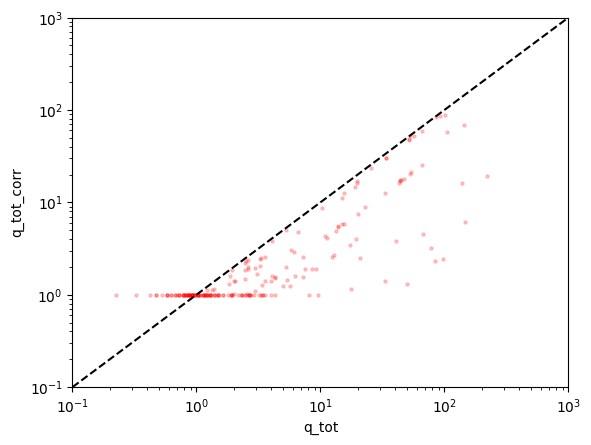

In [53]:
das = get_corrected_charge_v(dom_pos, q_exp, loss_pos, track_pos, track_dir_xyz)
corr_q = jnp.clip(das * q_tot, min=1)


fig, ax = plt.subplots()
plt.plot([0.1, 1000], [0.1, 1000], color='black', linestyle='dashed')
plt.scatter(q_tot, corr_q, s=5, alpha=0.2, color='red')
plt.xlabel('q_tot')
plt.ylabel('q_tot_corr')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 10**3])
plt.xlim([0.1, 10**3])

(0.1, 1000)

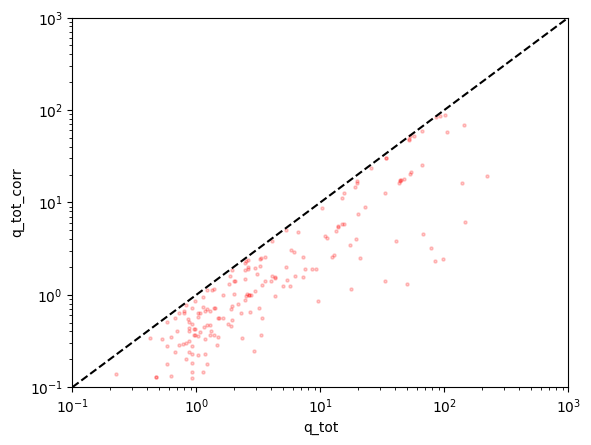

In [54]:
das = get_corrected_charge_v(dom_pos, q_exp, loss_pos, track_pos, track_dir_xyz)
corr_q = das * q_tot


fig, ax = plt.subplots()
plt.plot([0.1, 1000], [0.1, 1000], color='black', linestyle='dashed')
plt.scatter(q_tot, corr_q, s=5, alpha=0.2, color='red')
plt.xlabel('q_tot')
plt.ylabel('q_tot_corr')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 10**3])
plt.xlim([0.1, 10**3])

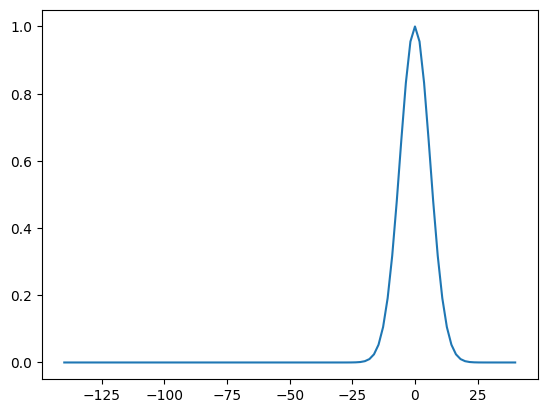

In [55]:
xvals = np.linspace(-140, 40, 100)
yvals = asym_gaussian(xvals, 6, 1)
plt.plot(xvals, yvals)

In [56]:
from lib.simdata_i3 import I3SimHandler
import sys, os

In [13]:
bp = '/home/storage2/hans/i3files/alerts/bfrv2/'
sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_event_1722_N100_from_0_to_100_1st_pulse_charge_correction.ftr'),
                              os.path.join(bp, 'pulses_ds_event_1722_N100_from_0_to_100_1st_pulse_charge_correction.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

In [14]:
event_index = 50

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)
event_data_corr = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses, charge_key = 'corrected_charge')

muon energy: nan TeV


KeyError: "['corrected_charge'] not in index"

In [ ]:
print(event_data_corr)

In [ ]:
fig, ax = plt.subplots()
plt.plot([0.1, 1000], [0.1, 1000], color='black', linestyle='dashed')
plt.scatter(event_data['charge'], np.clip(event_data_corr['charge'], a_min=1.0, a_max=None), s=5, alpha=0.2, color='red')
plt.xlabel('q_tot')
plt.ylabel('q_tot_corr')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 10**3])
plt.xlim([0.1, 10**3])